In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
from importlib import reload
import warnings
import ot
from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

In [2]:
# load ann data
resolution = 100000
population_path = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_anndata.h5ad"

start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
adata

Time taken to read the file: 9.49 seconds
Memory usage: current 1.53 GB, difference +1.53 GB


AnnData object with n_obs × n_vars = 25681 × 2756467
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes'
    uns: 'base_resolution', 'chrom_sizes'

In [3]:
adata.obs.head()

,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,ATACSeq_3,CTCF,H3K27ac,H3K27me3,RNA_1,RNA_2,RNA_3,RNA_4,RNA_5,RNA_6
bin_name,,,,,,,,,,,,,,,,,,,,,
chr9:1210,0,121000000,121100000,13913,9,1210,359,Ulk4,1,0.732026,...,0.876378,0.839470,0.426339,0.572455,NaN,0.060715,0.135441,0.084549,0.076785,0.090620
chr19:265,1,26500000,26600000,24283,19,265,392,Smarca2;Gm48775;Gm20616,3,0.548078,...,0.457881,0.591601,0.341745,1.072074,0.111940,NaN,0.111940,0.107590,NaN,NaN
chr4:1270,2,127000000,127100000,6638,4,1270,385,Tmem35b;Gm12943;Dlgap3;Zmym6,4,0.868742,...,0.915448,1.185766,2.462923,0.123129,1.144544,1.911008,0.302190,1.045680,2.153023,0.251087
chr8:212,3,21200000,21300000,11613,8,212,1039,,0,0.009509,...,0.009405,0.003237,0.004630,0.022603,NaN,NaN,NaN,0.081824,0.026729,0.086667
chr10:579,4,57900000,58000000,14526,10,579,832,,0,0.000000,...,0.000000,0.000000,0.000000,0.001373,NaN,NaN,NaN,NaN,NaN,NaN


# gather files

In [4]:
dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_scores/"

file_list = sorted(glob.glob(f"{dpath}*_{resolution}_*"))
print(f"{len(file_list)} files")

read_columns = [
    'bin_name',
    'ce_singular_vector_1', 
    'ce_eigenvector_centrality',
    'ce_betweenness_centrality',
    'ce_pagerank',
    'hge_singular_vector_1',
    'hge_logexp_unweighted',
    'hge_logexp_degree_weighted',
    'hge_logexp_RNA_weighted',
    'hge_logexp_ATAC_weighted',
]

df = []

for fpath in file_list:
    tmp = pd.read_csv(fpath, usecols=read_columns)
    df.append(tmp)

df = pd.concat(df, ignore_index=True)
df = df.set_index('bin_name')
print(f"{df.shape=}")
df.head()

20 files
df.shape=(25222, 9)


,ce_singular_vector_1,ce_eigenvector_centrality,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted
bin_name,,,,,,,,,
chr1:30,0.000000,0.000000,0.611540,0.000000,0.000000,0.989650,0.010889,0.222880,0.362456
chr1:31,0.286755,0.286755,0.019923,0.294626,0.089115,0.993510,0.380288,0.433499,0.447548
chr1:32,0.242861,0.242861,0.115415,0.238566,0.070560,0.993730,0.318448,0.233929,0.545448
chr1:33,0.426745,0.426747,0.055643,0.459709,0.156297,0.994963,0.561522,0.219306,0.633652
chr1:34,0.472463,0.472464,0.968913,0.461114,0.128972,0.993860,0.462167,0.211121,0.697355


# merge 'em'

In [5]:
adata.obs = pd.merge(
    adata.obs, 
    df, 
    how='left',
    left_index=True,
    right_index=True,
    
)
adata.obs.head()

,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,RNA_6,ce_singular_vector_1,ce_eigenvector_centrality,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted
bin_name,,,,,,,,,,,,,,,,,,,,,
chr9:1210,0,121000000,121100000,13913,9,1210,359,Ulk4,1,0.732026,...,0.090620,0.429794,0.429793,0.142115,0.395713,0.546374,0.384391,0.559562,0.141385,0.731020
chr19:265,1,26500000,26600000,24283,19,265,392,Smarca2;Gm48775;Gm20616,3,0.548078,...,NaN,0.808835,0.808839,0.030398,0.843493,0.794243,0.144703,0.777832,0.102908,0.552709
chr4:1270,2,127000000,127100000,6638,4,1270,385,Tmem35b;Gm12943;Dlgap3;Zmym6,4,0.868742,...,0.251087,0.452423,0.452420,0.020041,0.464378,0.350580,0.991255,0.753432,0.786097,0.929975
chr8:212,3,21200000,21300000,11613,8,212,1039,,0,0.009509,...,0.086667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr10:579,4,57900000,58000000,14526,10,579,832,,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# develop a low-dimensional embedding

X_svd.shape=(25681, 60)


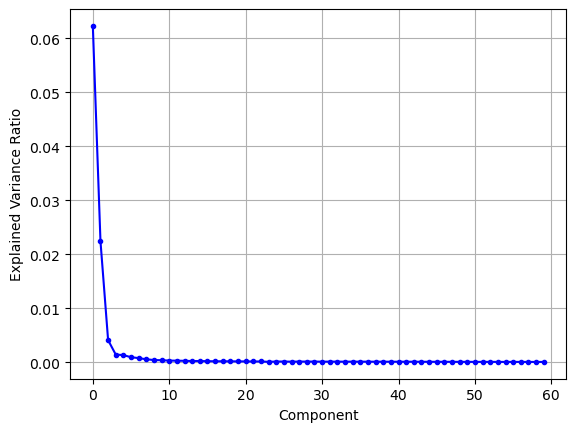

In [6]:
n_components = 60

svd = TruncatedSVD(
    n_components=n_components, 
    n_iter=5,
)

X_svd = svd.fit_transform(adata.X)
print(f"{X_svd.shape=}")
adata.obsm['X_svd'] = X_svd

adata.uns['explained_variance_ratio'] = svd.explained_variance_ratio_
adata.uns['singular_values'] = svd.singular_values_

plt.plot(
    adata.uns['explained_variance_ratio'],
    marker=".", 
    linestyle='-', 
    color='blue',
)
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True) 
plt.show()

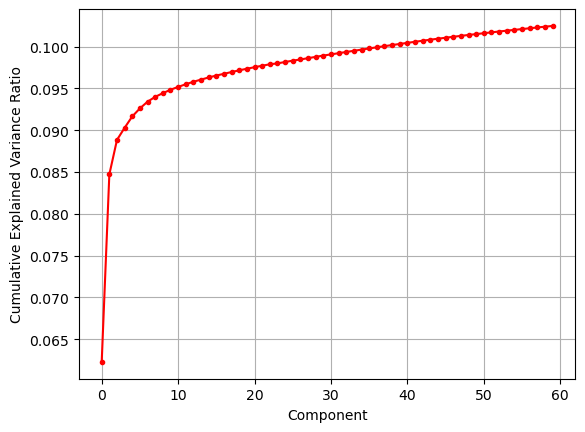

In [7]:
# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(adata.uns['explained_variance_ratio'])

# Plot the cumulative explained variance
plt.plot(
    cumulative_explained_variance,
    marker=".",
    linestyle='-',
    color='red'
)

plt.xlabel('Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [8]:
# break

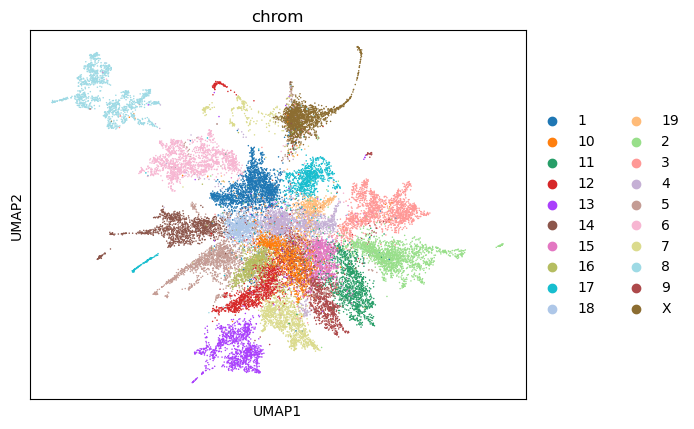

In [9]:
sc.pp.neighbors(
    adata,
    n_neighbors=25,
    use_rep='X_svd',
)

sc.tl.umap(
    adata,
    min_dist=0.45,
)

adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]

sc.pl.umap(
    adata,
    color='chrom'
)

In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

pdf = adata.obs.copy()
pdf = pdf.sort_values(by='chrom')

cmap = 'tab20'

sns.scatterplot(
    data=pdf,
    y='UMAP 2',
    x='UMAP 1',
    s=15,
    ec='none',
    c='k',
    zorder=1,
)

sns.scatterplot(
    data=pdf,
    y='UMAP 2',
    x='UMAP 1',
    s=5,
    ec='none',
    palette=cmap,
    hue='chrom',
    zorder=5,
)

sns.move_legend(
    plt.gca(),
    title='Chromosome',
    loc='center right',
    ncols=3,
    markerscale=2,
    bbox_to_anchor=(1.9, 0.5)
)

plt.yticks([])
plt.xticks([])
sns.despine()

In [ ]:
list(adata.obs.columns)

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

color_by = 'hge_singular_vector_1'
pdf = adata.obs.copy()

pdf = pdf.sort_values(
    by=color_by,
    ascending=True,
)

cmap = 'viridis'

sns.scatterplot(
    data=pdf,
    y='UMAP 2',
    x='UMAP 1',
    s=15,
    ec='none',
    c='k',
    zorder=1,
)

sns.scatterplot(
    data=pdf,
    y='UMAP 2',
    x='UMAP 1',
    s=3,
    ec='none',
    palette=cmap,
    hue=color_by,
    zorder=5,
)

sns.move_legend(
    plt.gca(),
    title=color_by,
    loc='center right',
    ncols=2,
    markerscale=2,
    bbox_to_anchor=(1.9, 0.5)
)

plt.yticks([])
plt.xticks([])
sns.despine()

In [ ]:
break

In [ ]:
A = adata.X @ adata.X.T

print(f"{A.shape=}")

In [ ]:
break

In [ ]:
corr = adata.obs[['n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
       'CTCF', 'H3K27ac', 'H3K27me3', 'ce_singular_vector_1', 'ce_eigenvector_centrality',
       'ce_betweenness_centrality', 'ce_pagerank', 'hge_singular_vector_1',
       'hge_logexp_unweighted', 'hge_logexp_degree_weighted',
       'hge_logexp_RNA_weighted', 'hge_logexp_ATAC_weighted']].corr()

sns.heatmap(
    corr,
    square=True,
    cbar_kws={'shrink' : 0.45},
    cmap='bwr'
)

In [ ]:
break

In [ ]:
features = [
    # 'degree', 'n_genes', 
    # 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 
    # 'RNA_1', 'RNA_2', 'RNA_3','RNA_4', 'RNA_5', 'RNA_6', 
    # 'chrom_degree', 
    'ce_singular_vector_1','ce_eigenvector_centrality', 'ce_betweenness_centrality', 'ce_pagerank',
    'hge_singular_vector_1', 'hge_logexp_unweighted','hge_logexp_degree_weighted','hge_logexp_RNA_weighted','hge_logexp_ATAC_weighted',
]

prefix = 'obs_'

adata = an.AnnData(
    X=df[features].fillna(0.0).copy(), 
    obs=df.add_prefix(prefix),
)

adata.obs['chromosome'] = adata.obs['obs_chrom'].apply(lambda x : f"chr{x}")

adata

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)

sc.tl.leiden(adata,resolution=0.5)

sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=['chromosome', 'leiden',],
    ncols=1
)

In [ ]:
break

# Load data

In [ ]:
population_path = "/scratch/indikar_root/indikar1/shared_data/higher_order/anndata/population_mESC_100000_features.h5ad"
start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
# free up some memory
del adata.uns['gene_map']
del adata.uns['gdf']
sc.logging.print_memory_usage()
adata

# QC

In [ ]:
def find_outliers_iqr(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

adata.obs['outlier'] = find_outliers_iqr(adata.obs['degree'])

print(adata.obs[adata.obs['outlier']][['bin', 'degree', 'outlier']].shape)
adata.obs[adata.obs['outlier']][['bin', 'degree', 'outlier']].head()

In [ ]:
# remove outliers
remove_bins = adata.obs[adata.obs['outlier']].index.to_list()
print(f"Removing top {len(remove_bins)} outlier loci: ")
print(remove_bins[:10])

adata = adata[~adata.obs_names.isin(remove_bins), :].copy()

print('done!')

In [ ]:
break

# Add features

In [ ]:
# add the principal singular value of the incidence matrix
H = adata.to_df().copy()
print(f"Raw: {H.shape=}")
H = H.T.drop_duplicates().T
print(f"De-duped: {H.shape=}")

svd = TruncatedSVD(n_components=1, n_iter=10)
adata.obs['singular_vector_1'] = ut.min_max(svd.fit_transform(H))

# hypergraph centralities
hge_functions = {
    'hge_logexp_unweighted' : {
        'function' : 'log-exp',
        'weights' : None,
    },
    'hge_logexp_RNA_weighted' : {
        'function' : 'log-exp',
        'weights' : 1 / (adata.obs.loc[H.index, 'RNA_2'].values + 1)
    },
    'hge_logexp_ATAC_weighted' : {
        'function' : 'log-exp',
        'weights' : 1 / (adata.obs.loc[H.index, 'ATACSeq_1'].values + 1)
    },
}


hge_centralities = []

for label, d in hge_functions.items():
    print(f"Starting {label}....")
    start_time = time.time()  # Record start time
    node, edge = central.nonlinear_eigenvector_centrality(
        H,
        function=d['function'],
        node_weights=d['weights'],
    )

    hge_centralities.append(label)
    adata.obs[label] = ut.min_max(node)

    end_time = time.time()  # Record end time
    print(f"{label} calculation took: {end_time - start_time:.2f} seconds")

adata

# Feature X

In [ ]:
adata.obs.columns

In [ ]:
break

In [ ]:
features = [
    'degree', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
    'CTCF', 'H3K27ac', 'H3K27me3', 
    'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 
]
adata.obsm['X_feature'] = adata.obs[features]
adata

In [ ]:
break

# Cliqiue-expansion

In [ ]:
matrix.expand_and_normalize_anndata(adata)
adata